# Deep Learning for System Identification
## Introduction: Least-squares estimation and simulation error minimization
### Authors: Dario Piga, Marco Forgione, IDSIA SUPSI/USI, Lugano, Switzerland

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

### Load data from the [Cascaded Tanks benchmark](https://www.nonlinearbenchmark.org/benchmarks/cascaded-tanks)

In [2]:
dataset = pd.read_csv(
    os.path.join("..", "..", "data", "CascadedTanks", "dataBenchmark.csv")
)  # change path according to the location of your csv file

In [3]:
dataset.head()

,uEst,uVal,yEst,yVal,Ts,Unnamed: 5
0,3.2567,0.97619,5.2050,4.9728,4.0,NaN
1,3.2466,0.99921,5.2154,4.9722,NaN,NaN
2,3.2309,1.01720,5.2215,4.9703,NaN,NaN
3,3.2097,1.03180,5.2142,4.9880,NaN,NaN
4,3.1836,1.04560,5.2001,4.9825,NaN,NaN


In [4]:
# rename the columns in training and test sequences (we typically call validation set the one used to tune algorithms' hyper-parameters)
dataset = dataset.rename(
    columns={
        "uEst": "u_train",
        "uVal": "u_test",
        "yEst": "y_train",
        "yVal": "y_test",
    }
)

dataset.head()

,u_train,u_test,y_train,y_test,Ts,Unnamed: 5
0,3.2567,0.97619,5.2050,4.9728,4.0,NaN
1,3.2466,0.99921,5.2154,4.9722,NaN,NaN
2,3.2309,1.01720,5.2215,4.9703,NaN,NaN
3,3.2097,1.03180,5.2142,4.9880,NaN,NaN
4,3.1836,1.04560,5.2001,4.9825,NaN,NaN


### Dataset visualization

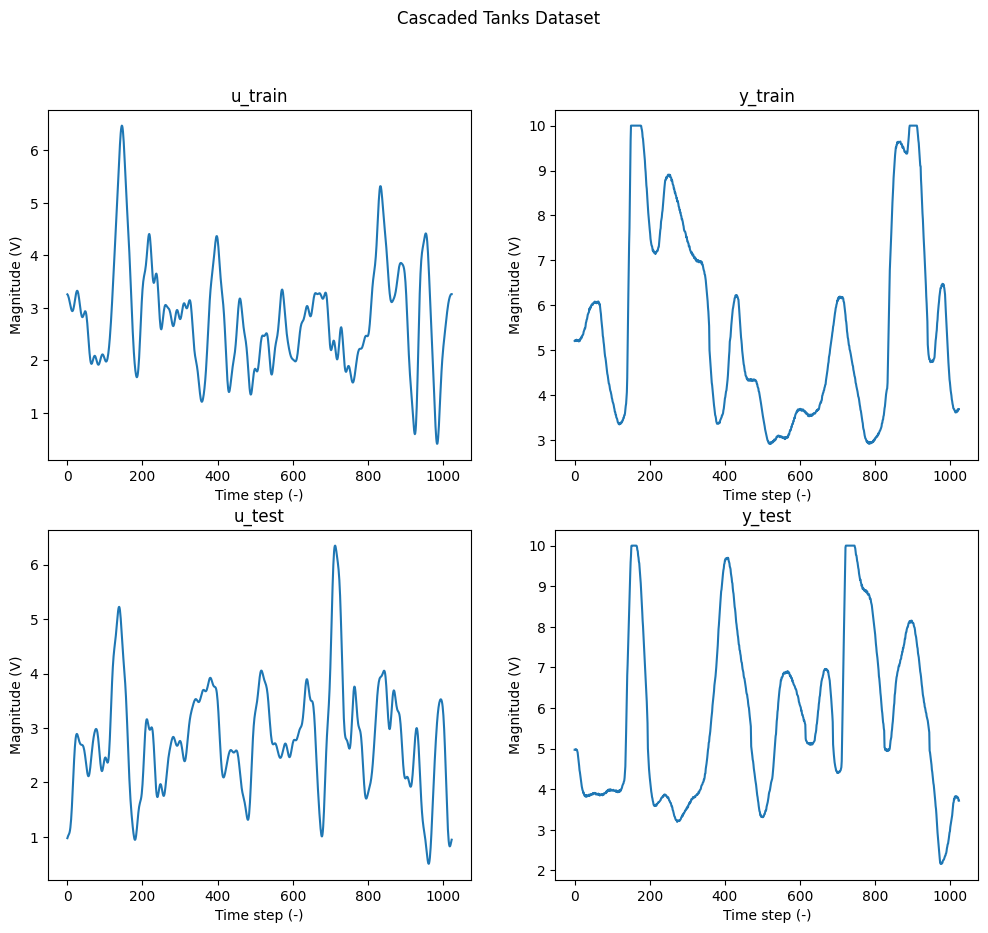

In [5]:
plt.figure(figsize=(12, 10))
plt.suptitle("Cascaded Tanks Dataset")
cols, rows = 2, 2

sequence_names = ("u_train", "y_train", "u_test", "y_test")

for i, n in enumerate(sequence_names):
    plt.subplot(cols, rows, i + 1)
    plt.plot(dataset[n])
    plt.title(sequence_names[i])
    plt.xlabel("Time step (-)")
    plt.ylabel("Magnitude (V)")

### Normalize data (good practice)

In [6]:
u_train = np.array(dataset["u_train"])
y_train = np.array(dataset["y_train"])

u_test = np.array(dataset["u_test"])
y_test = np.array(dataset["y_test"])
u_train.shape, y_train.shape

((1024,), (1024,))

In [7]:
# compute statistics on the training set
u_mean = np.mean(u_train)
u_std = np.std(u_train)
y_mean = np.mean(y_train)
y_std = np.std(y_train)

# normalize the training and test sets with the training set statistics
u_train = (u_train - u_mean) / u_std
u_test = (u_test - u_mean) / u_std

y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

print(f"Training input: mean = {np.mean(u_train):.2f}; std = {np.std(u_train):.2f}")
print(f"Training output: mean = {np.mean(y_train):.2f}; std = {np.std(y_train):.2f}")

print(f"Test input: mean = {np.mean(u_test):.2f}; std = {np.std(u_test):.2f}")
print(f"Test output: mean = {np.mean(y_test):.2f}; std = {np.std(y_test):.2f}")

Training input: mean = 0.00; std = 1.00
Training output: mean = -0.00; std = 1.00
Test input: mean = 0.00; std = 1.00
Test output: mean = 0.07; std = 0.97


## Part I: Linear regression



We would like to fit a linear *AutoRegressive eXogenous* (ARX) model with structure:
$$
M({\theta}) : 
\hat y(k) = \overbrace{\begin{bmatrix}  y(k-1)& \dots& y(k-n_a)& u(k)& \dots & u(k-n_b)  \end{bmatrix}}^{=\phi^\top(k)} {\theta}.
$$

Here, the vector $\theta$ contains the $n_a + n_b + 1$ ARX model coefficients:

$$ \theta = \begin{bmatrix}a_1 & a_1 & \dots & a_{n_a} &  b_0 & b_1 & \dots & b_{n_b}\end{bmatrix}^\top.$$

The extension to a NARX structure where the regressor $\phi(k)$ contains non-linear terms of $u(k), y(k)$ is trivial.

In [8]:
# create regressor
na = 2  # output lag
nb = 2  # input lags

### Create regressor

We first need to build the regression matrix $\Phi$ containing in each row the regressor vectors $\phi(k)$:

\begin{equation*}
\overbrace{
\begin{bmatrix}
\hat y(1) \\
\vdots \\
\hat y(k)\\
\vdots \\
\hat y(N)) \\
\end{bmatrix}
}^{=\hat Y}= 
\overbrace{
\begin{bmatrix}
y(0) & \dots  & y(1-n_a) & u(1) & \dots & u(1 - n_b)\\
\vdots \\
y(k-1) & \dots &y(k-n_a) & u(k) & \dots & u(k-n_b)\\
\vdots \\
y(N-1) & \dots  & y(N-n_a) & u(N) & \dots & u(N - n_b)\\
\end{bmatrix}
}^{=\Phi}
\theta
\end{equation*}

We actually skip the first $n = \max(n_a, n_b)$ rows, as the regressor is not defined there...

In [9]:
n = max((na, nb))  # number of initial conditions

N_train = np.shape(y_train)[0]  # number of samples
phi_train = np.zeros((N_train - n, na + nb + 1))
for idx in range(n, N_train):
    y_lag = np.flip(y_train[idx - na : idx]) # y(k-1), ..., y(k-na), 
    u_lag = np.flip(u_train[idx - nb : idx + 1]) # u(k), ..., u(k-nb)
    phi_train[idx - n, :] = np.concatenate((y_lag, u_lag))

N_test = np.shape(y_test)[0]  # number of samples
phi_test = np.zeros((N_test - n, na + nb + 1))
for idx in range(n, N_test):
    y_lag = np.flip(y_test[idx - na : idx]) # y(k-1), ..., y(k-na), 
    u_lag = np.flip(u_test[idx - nb : idx + 1]) # u(k), ..., u(k-nb)
    phi_test[idx - n, :] = np.concatenate((y_lag, u_lag))

# The regressors are associated to the output from time n to time N-1
y_train_ls = np.reshape(y_train[n:], (-1, 1))
y_test_ls = np.reshape(y_test[n:], (-1, 1))

In [10]:
phi_train.shape, y_train_ls.shape

((1022, 5), (1022, 1))

### Least-squares estimate

We obtain the least squares estimate by solving:

$$\theta_{LS} = (\Phi^\top \Phi)^{-1}\Phi^\top Y $$

In [11]:
theta_ls = np.linalg.solve(
    np.matmul(phi_train.transpose(), phi_train),  # Phi_train^T * Phi_train
    np.matmul(phi_train.transpose(), y_train_ls),  # Phi_train^T * Y
)
print(f"Least-square estimate: \n {theta_ls}")
# theta_ls_ = np.linalg.lstsq(phi_train, y_train_ls, rcond=None)[0]# alternative (better) way to compute the least-square estimate

Least-square estimate: 
 [[ 1.66078959]
 [-0.66568496]
 [ 0.06740859]
 [-0.17520155]
 [ 0.1192033 ]]


# Training using scikit-learn

In [12]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=False)  # no intercept
lin_model.fit(phi_train, y_train_ls)

# comparison of theta coefficients with results of LS:
print(f"Scikit-learn coefficients: \n {lin_model.coef_}")
print(f"Explicit Least squares coefficients: \n {theta_ls.transpose()}")

Scikit-learn coefficients: 
 [[ 1.66078959 -0.66568496  0.06740859 -0.17520155  0.1192033 ]]
Explicit Least squares coefficients: 
 [[ 1.66078959 -0.66568496  0.06740859 -0.17520155  0.1192033 ]]


# Testing one-step prediction

In [13]:
def regression_metrics(y_true, y_model):
    y_true = y_true.ravel() # flatten to avoid ambiguity in shape
    y_model = y_model.ravel()
    err = y_true - y_model
    MSE = np.mean(err**2)
    R2 = 1 - (MSE / np.mean((y_true - np.mean(y_true)) ** 2))
    return MSE, R2

Training performance:
MSE: 0.0005; R2: 0.9995
Test performance:
MSE: 0.0006; R2: 0.9993


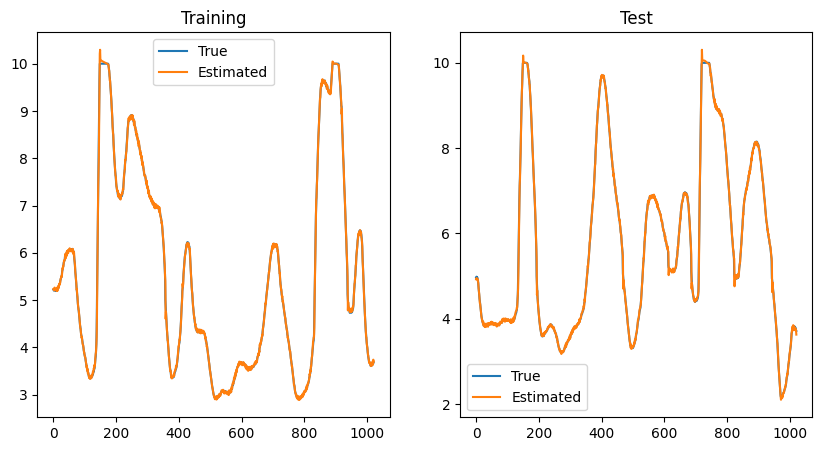

In [14]:
y_train_hat = np.matmul(phi_train, theta_ls) # phi_train @ theta_ls
mse_train, R2_train = regression_metrics(y_train_ls, y_train_hat)
print("Training performance:")
print(f"MSE: {mse_train:.4f}; R2: {R2_train:.4f}")

y_test_hat = np.matmul(phi_test, theta_ls)
mse_test, R2_test = regression_metrics(y_test_ls, y_test_hat)
print("Test performance:")
print(f"MSE: {mse_test:.4f}; R2: {R2_test:.4f}")


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(y_train_ls * y_std + y_mean, label="True")
plt.plot(y_train_hat * y_std + y_mean, label="Estimated")
plt.title("Training")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_ls * y_std + y_mean, label="True")
plt.plot(y_test_hat * y_std + y_mean, label="Estimated")
plt.title("Test")
plt.legend()
plt.show()

### Question: Performance seems to be great! Do you think we obtained a good model?

# Testing open-loop simulation

In [15]:
# simulation performance
def simulate(theta, u, na, nb, y0=None):

    n = np.max((na, nb))
    N = u.shape[0]
    y_sim = np.zeros(N)
    if y0 is not None:
        y_sim[0:n] = y0

    for idx in range(n, N):
        # the regressor vector is built on the fly based on the previous *simulated* values
        y_lag = np.flip(y_sim[idx - na : idx])  # \hat y(k-1), ..., \hat y(k-na) 
        u_lag = np.flip(u[idx - nb : idx + 1])  # u(k), u(k-1), ..., u(k-nb)
        phi_sim = np.concatenate((y_lag, u_lag))
        y_sim[idx] = np.matmul(phi_sim, theta)[0]

    return y_sim

Train - MSE: 0.0813, R2: 0.9188
Test - MSE: 0.0988, R2: 0.8951


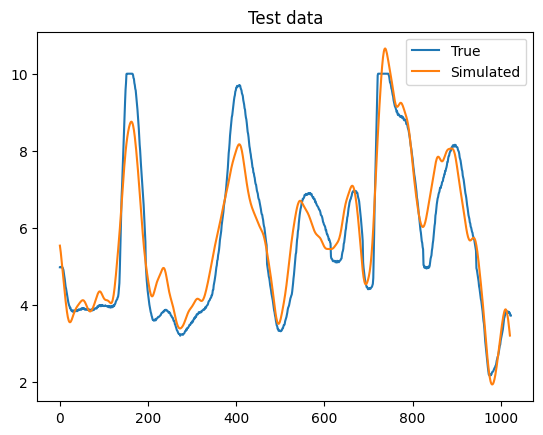

In [16]:
y_train_sim = simulate(theta_ls, u_train, na, nb)
mse_train, R2_train = regression_metrics(y_train[n:], y_train_sim[n:])
print(f"Train - MSE: {mse_train:.4f}, R2: {R2_train:.4f}")

y_test_sim = simulate(theta_ls, u_test, na, nb, y0=np.array([0, 0]))
mse_test, R2_test = regression_metrics(y_test[n:], y_test_sim[n:])
print(f"Test - MSE: {mse_test:.4f}, R2: {R2_test:.4f}")

plt.figure()
plt.plot(y_test * y_std + y_mean, label="True"),
plt.plot(y_test_sim[n:] * y_std + y_mean, label="Simulated")
plt.title("Test data")
plt.legend()
plt.show()

## Part II: Simulation error minimization (Implementation based on PyTorch)

In [17]:
import torch
torch.random.manual_seed(0)


# Simulation error minimization as a differentiable loss function
def simulation_loss(theta, u, y, na, nb):

    n = np.max((na, nb))
    seq_len = u.shape[0]
    y_sim = torch.zeros(seq_len, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    u = torch.tensor(u, dtype=torch.float32)

    for idx in range(n, seq_len):

        # build the regressor with previously *simulated* outputs and inputs
        y_lag = torch.flip(y_sim[idx - na : idx], dims=[0]) # \hat y(k-1), ..., \hat y(k-na) 
        u_lag = torch.flip(u[idx - nb : idx + 1], dims=[0]) # u(k), u(k-1), ..., u(k-nb)
        phi_sim = torch.cat((y_lag, u_lag))

        y_sim[idx] = torch.matmul(phi_sim, theta)

    loss = torch.mean((y[n:] - y_sim[n:]) ** 2)

    return loss

In [18]:
# initialize the parameters to the lest-square solution
theta = torch.tensor(theta_ls, dtype=torch.float32, requires_grad=True)  

In [19]:
loss = simulation_loss(theta, u_train, y_train, na, nb)
loss

tensor(0.0813, grad_fn=<MeanBackward0>)

In [20]:
loss.backward() # run automatic differentiation...

In [21]:
theta.grad # gradients wrt theta are computed!

tensor([[13.5427],
        [13.9282],
        [-4.5367],
        [-4.5816],
        [-4.6260]])

In [22]:
# iterative gradient-based optimization of the simulation loss

In [23]:
#max_iter = 10
max_iter = 200
lr = 1e-3

optimizer = torch.optim.Adam([theta], lr=lr)

for train_iter in range(max_iter):

    optimizer.zero_grad()

    # forward pass
    loss = simulation_loss(theta, u_train, y_train, na, nb)

    # backward pass (derivative computation)
    loss.backward()

    optimizer.step()

    if train_iter % 10 == 0:
        print(f"Iteration: {train_iter}, loss: {loss:2f}")

print(f"Estimated parameters: {theta}")

Iteration: 0, loss: 0.081305
Iteration: 10, loss: 0.079551
Iteration: 20, loss: 0.075462
Iteration: 30, loss: 0.074036
Iteration: 40, loss: 0.073532
Iteration: 50, loss: 0.073197
Iteration: 60, loss: 0.072908
Iteration: 70, loss: 0.072699
Iteration: 80, loss: 0.072530
Iteration: 90, loss: 0.072377
Iteration: 100, loss: 0.072249
Iteration: 110, loss: 0.072142
Iteration: 120, loss: 0.072054
Iteration: 130, loss: 0.071983
Iteration: 140, loss: 0.071926
Iteration: 150, loss: 0.071882
Iteration: 160, loss: 0.071848
Iteration: 170, loss: 0.071821
Iteration: 180, loss: 0.071801
Iteration: 190, loss: 0.071785
Estimated parameters: tensor([[ 1.6616],
        [-0.6674],
        [ 0.0594],
        [-0.1754],
        [ 0.1287]], requires_grad=True)


Train - MSE: 0.0813, R2: 0.9188
Test - MSE: 0.0860, R2: 0.9087


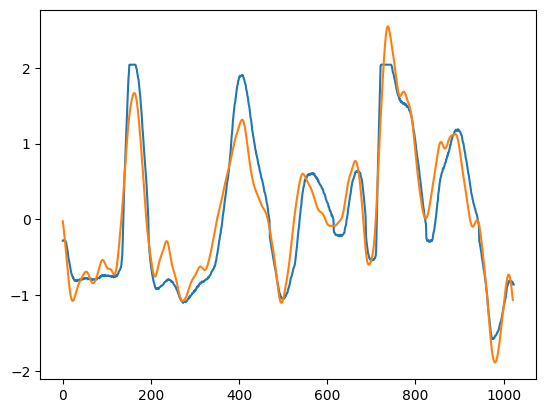

In [24]:
y_train_sim = simulate(theta.detach().numpy(), u_train, na, nb, y0=np.array([0, 0]))
mse_test, R2_test = regression_metrics(y_train[n:], y_train_sim[n:])
print(f"Train - MSE: {mse_train:.4f}, R2: {R2_train:.4f}")


y_test_sim = simulate(theta.detach().numpy(), u_test, na, nb, y0=np.array([0, 0]))
mse_test, R2_test = regression_metrics(y_test[n:], y_test_sim[n:])
print(f"Test - MSE: {mse_test:.4f}, R2: {R2_test:.4f}")

plt.figure()
plt.plot(y_test),
plt.plot(y_test_sim[n:])
plt.show()

# Part III: L1 Regularization


We deal with a NFIR model structure with a high-dimensional regressor:

$$
M({\theta}) : 
\hat y(k) = F^\top \bigg (u(k), u(k-1), \dots  u(k-n_b) \bigg) {\theta}
$$

- long memory ($n_b$ large)
- nonlinear transformations of past inputs (polynomials)


We apply **L1 Regularization** to perform **automatic selection** of a relevant subset of the regressor terms.

Discuss the impact of the **regularization parameter** on:
- model sparsity (i.e., number of non-zero coefficients),  
- and overall predictive performance.



### Build the regressor matrix

In [25]:
nfir = 300  # FIR lags (=nb for NARX)
max_power = 1 # linear FIR


# Each y and u term is expanded to [x, x^2, x^3]
reg_dim = (nfir + 1) * max_power  # original regressors times 3 (for x, x^2, x^3)


phi_train = np.zeros((y_train.shape[0] - nfir, reg_dim))
for idx in range(nfir, N_train):
    # regressors
    regs = np.flip(u_train[idx - nfir : idx + 1])
    # nonlinear expansion of regressors
    regs_exp = np.concatenate(
        [np.power(regs, i) for i in range(1, max_power + 1)]
    )  # x, x^2, x^3
    phi_train[idx - nfir, :] = regs_exp

phi_test = np.zeros((y_test.shape[0] - nfir, reg_dim))
for idx in range(nfir, N_test):
    regs = np.flip(u_test[idx - nfir : idx + 1])
    regs_exp = np.concatenate(
        [np.power(regs, i) for i in range(1, max_power + 1)]
    )  # x, x^2, x^3
    phi_test[idx - nfir, :] = regs_exp

# Align output
y_train_nfir = np.reshape(y_train[nfir:], (-1, 1))
y_test_nfir = np.reshape(y_test[nfir:], (-1, 1))

phi_train.shape, y_train_nfir.shape

((724, 301), (724, 1))

### FIR training without L1 regularization 

Least Squares implementation in PyTorch with gradient descent. We may use any other linear solver instead!

In [26]:
# FIR identification (without LASSO)

phi_train_t = torch.tensor(phi_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train_nfir, dtype=torch.float32)
theta = torch.randn((reg_dim, 1), dtype=torch.float32, requires_grad=True)


def MSE_loss(theta, reg_train_t, y_train_t):
    err = torch.matmul(reg_train_t, theta) - y_train_t
    loss = torch.mean(err**2)
    return loss


loss = MSE_loss(theta, phi_train_t, y_train_t)
loss

tensor(71.0319, grad_fn=<MeanBackward0>)

In [27]:
max_iter = 100_000
lr = 1e-3

optimizer = torch.optim.SGD([theta], lr=lr)

for train_iter in range(max_iter):

    optimizer.zero_grad()

    # forward pass
    loss = MSE_loss(theta, phi_train_t, y_train_t)

    # backward pass
    loss.backward()

    optimizer.step()

    if train_iter % 10_000 == 0:
        print(f"Iteration: {train_iter}, loss: {loss:2f}")

Iteration: 0, loss: 71.031876
Iteration: 10000, loss: 0.023489
Iteration: 20000, loss: 0.022027
Iteration: 30000, loss: 0.021981
Iteration: 40000, loss: 0.021964
Iteration: 50000, loss: 0.021950
Iteration: 60000, loss: 0.021938
Iteration: 70000, loss: 0.021926
Iteration: 80000, loss: 0.021915
Iteration: 90000, loss: 0.021904


In [28]:
# theta_fir_ls = np.linalg.lstsq(reg_train_t, y_train_t, rcond=None)[0]

In [29]:
# simulation performance
def simulate_fir(theta, u_sim, nfir, y0=None):

    N = u_sim.shape[0]
    y_sim = np.zeros(N)
    if y0 is not None:
        y_sim[0:nfir] = y0

    for idx in range(nfir, N):
        x_reg_sim = np.flip(u_sim[idx - nfir : idx + 1])
        y_sim[idx] = np.matmul(x_reg_sim, theta)[0]

    return y_sim

Train - MSE: 0.0219, R2_train 0.9746
Test - MSE: 0.1168, R2_test: 0.8652


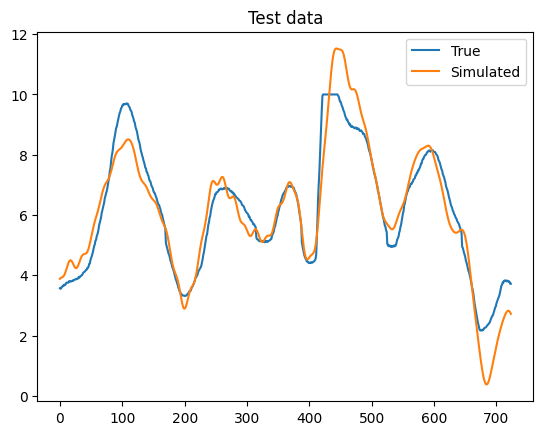

In [30]:
y_train_sim = simulate_fir(theta.detach().numpy(), u_train, nfir)
mse_train, R2_train = regression_metrics(y_train_nfir, y_train_sim[nfir:])
print(f"Train - MSE: {mse_train:.4f}, R2_train {R2_train:.4f}")


y_test_sim = simulate_fir(theta.detach().numpy(), u_test, nfir, y0=np.zeros(nfir))
mse_test, R2_test = regression_metrics(y_test_nfir, y_test_sim[nfir:])
print(f"Test - MSE: {mse_test:.4f}, R2_test: {R2_test:.4f}")

plt.figure()
plt.plot(y_test_nfir * y_std + y_mean, label="True"),
plt.plot(y_test_sim[nfir:] * y_std + y_mean, label="Simulated")
plt.title("Test data")
plt.legend()
plt.show()

### FIR training without L1 regularization 

Implementation in PyTorch with proximal gradient descent. We may use some specialized LASSO solver instead... 

Let us first implement soft thresholding, which is the proximal operator for the 1-norm, as a PyTorch function

In [31]:
def soft_thresholding(theta, th):
    # theta: tensor of parameters
    # th: threshold (scalar or tensor broadcastable to theta)
    return torch.sign(theta) * torch.maximum(
        torch.abs(theta) - th, torch.zeros_like(theta)
    )


theta_th = soft_thresholding(theta, th=1.0)
torch.concatenate((theta, theta_th), dim=1)

tensor([[-0.2054, -0.0000],
        [-0.4135, -0.0000],
        [ 0.3206,  0.0000],
        [-0.0139, -0.0000],
        [ 1.1374,  0.1374],
        [ 0.8733,  0.0000],
        [-0.2179, -0.0000],
        [-2.0760, -1.0760],
        [ 0.3337,  0.0000],
        [-1.2612, -0.2612],
        [ 0.3680,  0.0000],
        [ 0.3531,  0.0000],
        [ 0.1993,  0.0000],
        [ 1.3512,  0.3512],
        [ 1.2626,  0.2626],
        [-0.0862, -0.0000],
        [-1.1917, -0.1917],
        [-1.5532, -0.5532],
        [ 0.6721,  0.0000],
        [ 0.8461,  0.0000],
        [ 0.5833,  0.0000],
        [-1.6449, -0.6449],
        [-0.5041, -0.0000],
        [ 1.6232,  0.6232],
        [ 0.4604,  0.0000],
        [-0.9154, -0.0000],
        [-0.5275, -0.0000],
        [-0.1718, -0.0000],
        [ 1.0477,  0.0477],
        [ 1.2770,  0.2770],
        [ 0.6744,  0.0000],
        [-1.0731, -0.0731],
        [-0.7980, -0.0000],
        [-0.1185, -0.0000],
        [-0.6171, -0.0000],
        [ 0.1362,  0

Proximal Gradient Method for LASSO

In [32]:
# FIR identification with LASSO

theta = torch.randn((reg_dim, 1), dtype=torch.float32, requires_grad=True)

max_iter = 100_000
lr = 1e-3
lambda_l1 = 0.2  # l1 regularization strength

optimizer = torch.optim.SGD([theta], lr=lr)

for train_iter in range(max_iter):

    optimizer.zero_grad()

    # forward pass (loss computation)
    loss = MSE_loss(theta, phi_train_t, y_train_t)

    # backward pass (loss gradient computation)
    loss.backward()

    optimizer.step()

    with torch.no_grad():
        theta.data = soft_thresholding(theta.data, th=lambda_l1 * lr)

    if train_iter % 1000 == 0:
        print(f"Iteration: {train_iter}, loss: {loss:2f}")

Iteration: 0, loss: 481.270233
Iteration: 1000, loss: 2.288679
Iteration: 2000, loss: 0.838204
Iteration: 3000, loss: 0.456289
Iteration: 4000, loss: 0.295648
Iteration: 5000, loss: 0.212942
Iteration: 6000, loss: 0.144944
Iteration: 7000, loss: 0.113783
Iteration: 8000, loss: 0.095836
Iteration: 9000, loss: 0.088917
Iteration: 10000, loss: 0.081008
Iteration: 11000, loss: 0.088981
Iteration: 12000, loss: 0.092797
Iteration: 13000, loss: 0.096355
Iteration: 14000, loss: 0.098455
Iteration: 15000, loss: 0.099544
Iteration: 16000, loss: 0.100461
Iteration: 17000, loss: 0.100166
Iteration: 18000, loss: 0.099693
Iteration: 19000, loss: 0.099353
Iteration: 20000, loss: 0.099046
Iteration: 21000, loss: 0.098839
Iteration: 22000, loss: 0.098708
Iteration: 23000, loss: 0.098586
Iteration: 24000, loss: 0.098500
Iteration: 25000, loss: 0.098439
Iteration: 26000, loss: 0.098406
Iteration: 27000, loss: 0.098329
Iteration: 28000, loss: 0.098289
Iteration: 29000, loss: 0.098268
Iteration: 30000, los

In [33]:
print(f"Estimated parameters: {theta}")

Estimated parameters: tensor([[0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [7.3428e-03],
        [3.7461e-02],
        [3.3711e-02],
        [1.4699e-02],
        [7.7711e-04],
        [0.0000e+00],
        [2.6679e-01],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [8.9116e-02],
        [8.3069e-03],
        [2.5753e-02],
        [3.5311e-02],
        [3.6902e-02],
        [3.1707e-02],
        [2.2631e-02],
        [1.2496e-02],
        [2.5290e-03],
        [1.1599e-01],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [5.3491e-03],
        [1.3098e-02],
        [1.7711e-02],
        [1.7003e-02],
        [1

Train - MSE: 0.0979, R2_test: 0.8866
Test - MSE: 0.1144, R2_test: 0.8680


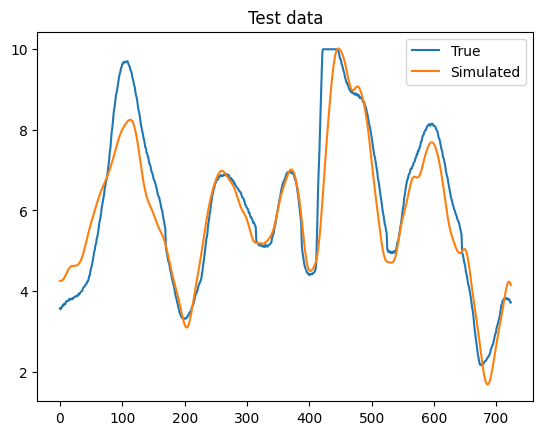

In [34]:
y_train_sim = simulate_fir(theta.detach().numpy(), u_train, nfir)
mse_train, R2_train = regression_metrics(y_train[nfir:], y_train_sim[nfir:])
print(f"Train - MSE: {mse_train:.4f}, R2_test: {R2_train:.4f}")


y_test_sim = simulate_fir(theta.detach().numpy(), u_test, nfir, y0=np.zeros(nfir))
mse_test, R2_test = regression_metrics(y_test[nfir:], y_test_sim[nfir:])
print(f"Test - MSE: {mse_test:.4f}, R2_test: {R2_test:.4f}")

plt.figure()
plt.plot(y_test[nfir:] * y_std + y_mean, label="True"),
plt.plot(y_test_sim[nfir:] * y_std + y_mean, label="Simulated")
plt.title("Test data")
plt.legend()
plt.show()

### Re-estimation only with regressors selected by L1-regularization

In [35]:
theta_nonzero = torch.abs(theta.data) > 1e-6

reg_train_sparse = phi_train[:, theta_nonzero.squeeze()]
reg_test_sparse = phi_test[:, theta_nonzero.squeeze()]


theta_sparse = np.linalg.solve(
    np.matmul(reg_train_sparse.transpose(), reg_train_sparse),
    np.matmul(reg_train_sparse.transpose(), y_train_nfir),
)
print(theta_sparse.shape)
print(f"Least-square estimate: \n {theta_sparse}")

(40, 1)
Least-square estimate: 
 [[  71.95899195]
 [-129.10513953]
 [ -43.76189302]
 [  64.04175307]
 [ 146.11375193]
 [-130.42858309]
 [   0.3094718 ]
 [  53.87189306]
 [   9.19723666]
 [ -22.37639632]
 [   4.74401372]
 [  22.56021872]
 [ -22.16590199]
 [ -49.93381085]
 [ -22.23435476]
 [  -3.55188388]
 [  86.70272729]
 [  84.92646811]
 [ -14.02906324]
 [ -28.0989391 ]
 [ -55.27984869]
 [ -68.32949322]
 [ -48.05991496]
 [ 120.84037167]
 [-155.22813453]
 [ -26.43746879]
 [  48.22794744]
 [ 118.57274638]
 [ 148.90299203]
 [  -5.34519384]
 [-155.33988442]
 [-182.46787368]
 [  74.93974751]
 [ 158.98738826]
 [ 149.87478383]
 [-206.29645497]
 [ -21.96771464]
 [ 180.64491724]
 [-254.85582169]
 [ 101.93416614]]


Train - MSE: 0.0350, R2_test: 0.9594
Test - MSE: 0.0834, R2_test: 0.9038


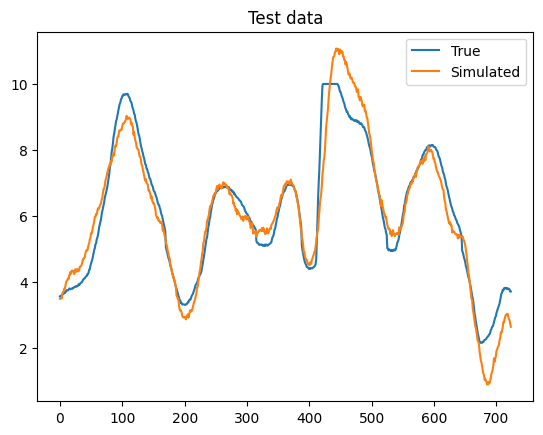

In [36]:
y_train_sim = np.matmul(reg_train_sparse, theta_sparse)
mse_train, R2_train = regression_metrics(y_train_nfir, y_train_sim)
print(f"Train - MSE: {mse_train:.4f}, R2_test: {R2_train:.4f}")


y_test_sim = np.matmul(reg_test_sparse, theta_sparse)
mse_test, R2_test = regression_metrics(y_test_nfir, y_test_sim)
print(f"Test - MSE: {mse_test:.4f}, R2_test: {R2_test:.4f}")

plt.figure()
plt.plot(y_test_nfir * y_std + y_mean, label="True"),
plt.plot(y_test_sim * y_std + y_mean, label="Simulated")
plt.title("Test data")
plt.legend()
plt.show()